# 1.1. Facebook Prophet exploration

## I - Setup

In [1]:
# Import of librairies

import mysql.connector as mariadb
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Importing plotly failed. Interactive plots will not work.


In [2]:
class sql_query:
    def __init__(self, credentials_path):
        self.db_credentials = pd.read_csv(credentials_path, index_col="Field")
      
    
    def __call__(self, query):
        
        mariadb_connection = mariadb.connect(
            user=self.db_credentials.loc["user"][0],
            password=self.db_credentials.loc["password"][0],
            host=self.db_credentials.loc["host"][0],
            port=3306,
            db = "db_velib")
        
        self.cursor = mariadb_connection.cursor()
    
        cursor = self.cursor
        cursor.execute(query)
        field_names = [i[0] for i in cursor.description]
        df = pd.DataFrame(cursor, columns=field_names)
        return df

## II. Adaptation pipeline

In [3]:
# Taking data from  station 9034 - Madeleine

request = sql_query("../../aws_mariadb_crendentials.csv")

query = """
SELECT DISTINCT * FROM velib_realtime
WHERE station_id = 9034
AND date_of_update > DATE("2020-05-05")
ORDER BY date_of_update ASC
"""

df_full = request(query)

In [4]:
df_full.head()

,station_id,operational_station,nb_free_docks,nb_total_free_bikes,nb_free_mechanical_bikes,nb_free_electrical_bikes,payment_totem,bike_return_possible,data_actualisation,date_of_update
0,9034,OUI,20,2,1,1,OUI,OUI,2020-05-04 23:26:49,2020-05-05 00:01:00
1,9034,OUI,20,2,1,1,OUI,OUI,2020-05-04 23:26:49,2020-05-05 00:02:00
2,9034,OUI,20,2,1,1,OUI,OUI,2020-05-04 23:26:49,2020-05-05 00:03:00
3,9034,OUI,20,2,1,1,OUI,OUI,2020-05-04 23:26:49,2020-05-05 00:04:00
4,9034,OUI,20,2,1,1,OUI,OUI,2020-05-04 23:26:49,2020-05-05 00:05:00


In [5]:
df = df_full[['date_of_update','nb_free_docks']]

# Adopting FB Prophet terminology for easier use
df.columns = ['ds','y']
df.head()

,ds,y
0,2020-05-05 00:01:00,20
1,2020-05-05 00:02:00,20
2,2020-05-05 00:03:00,20
3,2020-05-05 00:04:00,20
4,2020-05-05 00:05:00,20


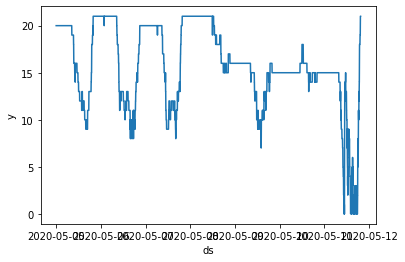

In [6]:
_ = sns.lineplot(x="ds", y="y", data=df)

In [7]:
step_to_predict = 60
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=step_to_predict, freq='min')
future.tail

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


<bound method NDFrame.tail of                       ds
0    2020-05-05 00:01:00
1    2020-05-05 00:02:00
2    2020-05-05 00:03:00
3    2020-05-05 00:04:00
4    2020-05-05 00:05:00
...                  ...
9848 2020-05-11 20:19:00
9849 2020-05-11 20:20:00
9850 2020-05-11 20:21:00
9851 2020-05-11 20:22:00
9852 2020-05-11 20:23:00

[9853 rows x 1 columns]>

In [8]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
9848,2020-05-11 20:19:00,9.146390,6.761261,11.373777
9849,2020-05-11 20:20:00,9.155167,6.892111,11.407726
9850,2020-05-11 20:21:00,9.163651,7.184834,11.466289
9851,2020-05-11 20:22:00,9.171843,6.898856,11.453863
9852,2020-05-11 20:23:00,9.179744,6.882838,11.452950


In [9]:
forecast_full = forecast
forecast_full['y'] = df['y']
# Replacing y Nan values with last values known
# forecast_full['y'].iloc[df.shape[0]:] = forecast_full['y'].iloc[df.shape[0]-1]
forecast_full['yhat_round'] = forecast_full['yhat'].apply(lambda x: round(x))

In [10]:
forecast_full.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y,yhat_round
0,2020-05-05 00:01:00,18.852388,18.603886,22.988833,18.852388,18.852388,1.958308,1.958308,1.958308,1.958308,1.958308,1.958308,0.0,0.0,0.0,20.810696,20.0,21
1,2020-05-05 00:02:00,18.848896,18.610593,23.175014,18.848896,18.848896,1.959026,1.959026,1.959026,1.959026,1.959026,1.959026,0.0,0.0,0.0,20.807922,20.0,21
2,2020-05-05 00:03:00,18.845405,18.773802,23.060858,18.845405,18.845405,1.959802,1.959802,1.959802,1.959802,1.959802,1.959802,0.0,0.0,0.0,20.805207,20.0,21
3,2020-05-05 00:04:00,18.841914,18.551020,22.992574,18.841914,18.841914,1.960635,1.960635,1.960635,1.960635,1.960635,1.960635,0.0,0.0,0.0,20.802548,20.0,21
4,2020-05-05 00:05:00,18.838422,18.471083,22.964047,18.838422,18.838422,1.961523,1.961523,1.961523,1.961523,1.961523,1.961523,0.0,0.0,0.0,20.799945,20.0,21


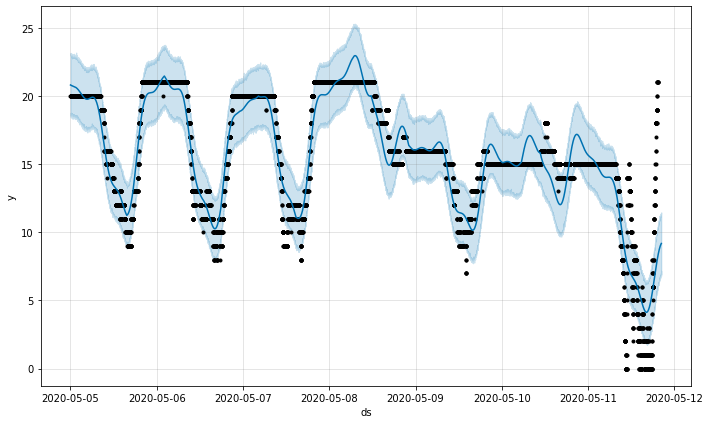

In [11]:
fig1 = m.plot(forecast)

## III. Graphical results

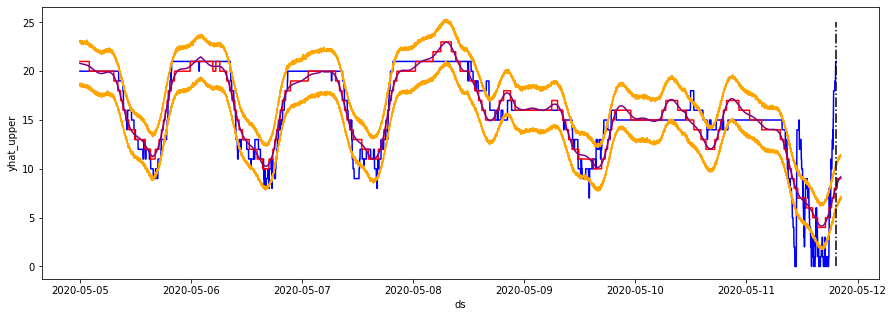

In [12]:
# Global graph

fig, axis = plt.subplots(figsize=(15,5))
sns.lineplot(x="ds", y="y",data=forecast_full, color="blue")
sns.lineplot(x="ds", y="yhat_round",data=forecast_full, color="red")
sns.lineplot(x="ds", y="yhat",data=forecast_full, color="purple")
sns.lineplot(x="ds", y="yhat_lower",data=forecast_full, color="orange")
sns.lineplot(x="ds", y="yhat_upper",data=forecast_full, color="orange")

x1, y1 = [forecast_full.ds.iloc[df.shape[0]], forecast_full.ds.iloc[df.shape[0]]], [0, 25]
ax = plt.plot(x1, y1, linestyle="dashdot", color="black")

plt.show()


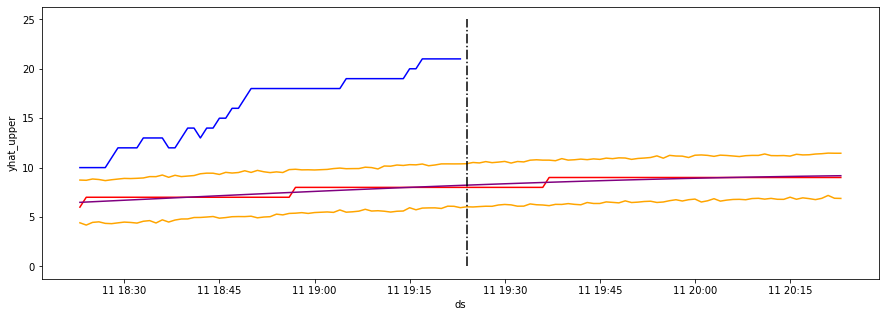

In [13]:
# Realtime Figure

fig, axis = plt.subplots(figsize=(15,5))
sns.lineplot(x="ds", y="y",data=forecast_full[-step_to_predict*2:], color="blue")
sns.lineplot(x="ds", y="yhat_round",data=forecast_full[-step_to_predict*2:], color="red")
sns.lineplot(x="ds", y="yhat",data=forecast_full[-step_to_predict*2:], color="purple")
sns.lineplot(x="ds", y="yhat_lower",data=forecast_full[-step_to_predict*2:], color="orange")
sns.lineplot(x="ds", y="yhat_upper",data=forecast_full[-step_to_predict*2:], color="orange")

x1, y1 = [forecast_full.ds.iloc[df.shape[0]], forecast_full.ds.iloc[df.shape[0]]], [0, 25]
ax = plt.plot(x1, y1, linestyle="dashdot", color="black")

plt.show()
